In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
sns.set_style("darkgrid")
sns.set_palette("rocket")
# sns.set_palette("mako")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

pi = np.pi

In [31]:
def autocovariance(k, H):
        return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) + abs(k + 1) ** (2 * H))

def cholesky_fbm(T, n, H, trajectories = 1, G = None, C = None):
    scale = (T /n) ** H
    if not G:
        G = np.zeros([n, n])
        for i in range(n):
            for j in range(i + 1):
                G[i, j] = autocovariance(i - j, H)
    if not C:
        C = np.linalg.cholesky(G)
    gn = np.random.normal(0.0, 1.0, (trajectories, n))
    fgn = np.dot(C, gn.T) * scale
    return np.insert(np.cumsum(fgn, 0)[:-1], 0, 0, axis=0)

def get_quantils(df, quantiles, ts):
    N = df.shape[0]
    qs = np.zeros((N, len(quantiles)))
    for i, row in df.iterrows():
        qs[i]= [np.quantile(row, q) for q in quantiles] 
    quantiles_Df = pd.DataFrame(qs.T, columns = ts)
    quantiles_Df["rang"] = quantiles
    return quantiles_Df


In [32]:
def EAMSD(df):
    x_0 = df[0]
    diff_sq = (df - x_0)**2
    return np.mean(diff_sq, 1)

def TAMSD(df, tau):
    return np.mean(np.diff(df, tau, 0)**2, 0)

In [33]:
def FOU(sigma, lambd, H, ts, trajectories = 1):
    n = len(ts)
    T = ts[-1]
    tsM = np.repeat(ts[:, None],  trajectories, 1)
    exp_lamd_t = np.exp(-lambd*tsM)
    fbm = cholesky_fbm(T, n+1, H, trajectories=trajectories)
    diff_fbm = np.diff(fbm, axis=0)
    O_u = sigma *exp_lamd_t * np.cumsum(np.exp(lambd*tsM)*diff_fbm, 0)  
    return O_u

In [34]:
def stable_random_variables_a(alpha):
    if alpha == 1:
        Omega = np.random.uniform(-pi/2, pi/2)
        return np.tan(Omega)
    else:
        Omega = np.random.uniform(-pi/2, pi/2)
        W = np.random.exponential(1)
        return np.sin(alpha*Omega)/np.cos(Omega)**(1/alpha)*(np.cos((alpha-1)*Omega)/W)**((1-alpha)/alpha)
    
def stable_random_variables_b(alpha, beta):
    Omega = np.random.uniform(-pi/2, pi/2)
    W = np.random.exponential(1)
    Delta_0 = np.arctan(beta*np.tan(pi*alpha/2))/alpha

    if alpha == 1:
        return 2/pi*((pi/2+beta*Omega)*np.tan(Omega)-beta*np.log(pi/2*W*np.cos(Omega)/(pi/2+beta*Omega)))
    else:
        a = np.sin(alpha*(Delta_0+Omega))/(np.cos(alpha*Delta_0)*np.cos(Omega))**(1/alpha)
        b = (np.cos(alpha*Delta_0+(alpha-1)*Omega)/W)**((1-alpha)/alpha)
        return a*b

def stable_random_variables_0(alpha, beta, gamma, delta):
    Z = stable_random_variables_a(alpha, beta)
    if alpha == 1:
        return gamma*Z+delta
    else:
        return gamma*(Z - beta*np.tan(pi*alpha/2)) + delta


def stable_random_variables_1(alpha, beta, gamma, delta):
    Z = stable_random_variables_b(alpha, beta)
    if alpha == 1:
        return gamma*Z + (delta + beta*2/pi*gamma*np.log(gamma))
    else:
        return gamma*Z+delta
    
def stable_random_variables(alpha, beta = 0, gamma=1, delta=0, stable_type = 1):
    if stable_type == 1:
        return stable_random_variables_1(alpha, beta, gamma, delta)
    elif stable_type ==0:
        return stable_random_variables_0(alpha, beta, gamma, delta)
    else:
        raise ValueError("Select bad stable_type!!!")
    
def  alpha_stable_process(alpha, beta, N, T=1, S_0 = 0):
    dt = T / N
    Z_t = [stable_random_variables(alpha, beta, gamma = dt**(1/alpha)) for _ in range(N)] 
    Z_t[0] = S_0
    return np.cumsum(Z_t)

In [35]:
def FAS(alpha, H, M, N, m, n):
    C =  (T /N) ** H
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))
    
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))

    C = C * (np.sum(np.abs(A)**alpha)**(-1/alpha))
    A = C * A

    Na = m * (M + N)
    A = np.fft.fft(A, Na)
    y= np.zeros((n, N))
    # y=[]
    for i in range(n):
        if alpha < 2:
            Z = np.array([stable_random_variables(alpha, 0) for _ in range(Na)])[None,:]
        elif alpha == 2:
            Z = np.random.randn(1, Na)

        Z = np.fft.fft(Z, Na)
        w = np.real(np.fft.ifft(Z * A, Na))
        y[i] = w[0][:N*m:m]
    return np.array(y)

# FBM

## (a) sample trajectories

In [10]:
T = 1
n = 2000
H = 0.5
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 50)

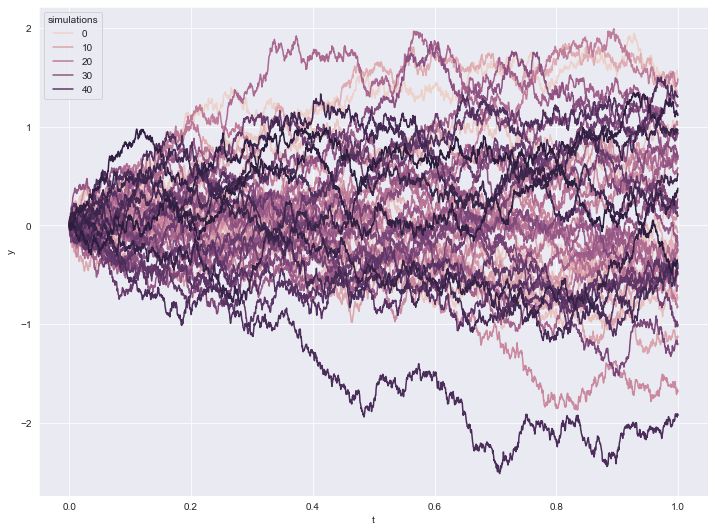

In [13]:
fig, ax=plt.subplots(figsize=(12, 9))

df_BH = pd.DataFrame(fbm)
df_BH["t"] = t_s
melt_df_BH = pd.melt(df_BH, "t", var_name="simulations", value_name="y")
sns.lineplot(data=melt_df_BH, x="t", y="y", hue="simulations")
plt.savefig(f"latex/images/sample_trajectories_FBM_H_{H}.png")

## quantile line,

In [14]:
T = 1
n = 1000
H = 0.666
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)

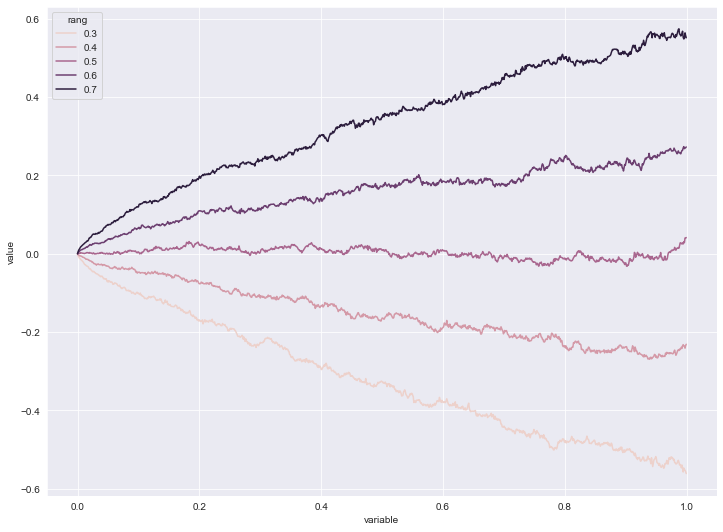

In [16]:
fig, ax=plt.subplots(figsize=(12, 9))
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(fbm), quantiles, t_s)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(data=quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")
plt.savefig("latex/images/quantile_lines_FBM_H_{H}.png")

## Variancve in time

In [17]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)

In [18]:
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    fbm = cholesky_fbm(T, n, H, trajectories)
    _df = pd.DataFrame(np.var(fbm, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

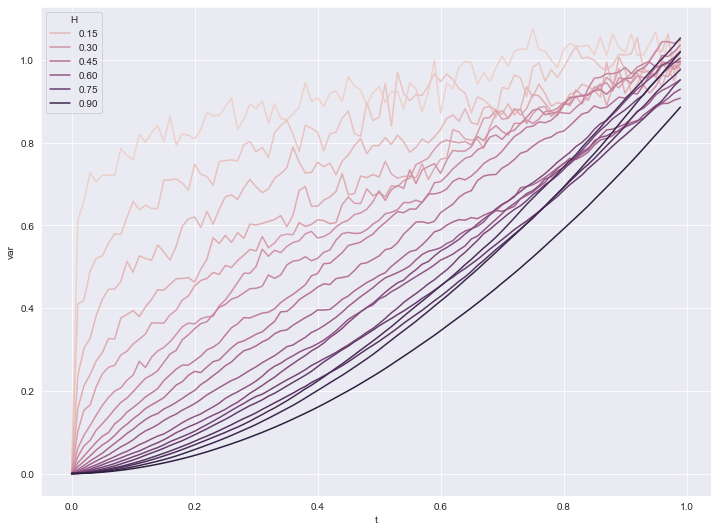

In [19]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_FBM.png")
plt.show()

## MSD

In [21]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    fbm = cholesky_fbm(T, n, H, trajectories)
    _df = pd.DataFrame(EAMSD(fbm), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

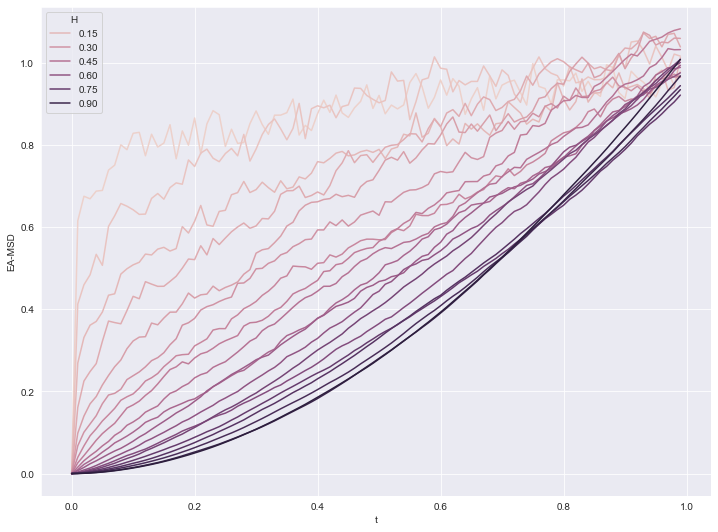

In [23]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "EA-MSD", hue = "H")
plt.savefig("latex/images/EA-MSD_FBM.png")
plt.show()

In [24]:
T = 1
n = 1000
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        fbm = cholesky_fbm(T, n, H, trajectories)
        _df = pd.DataFrame(TAMSD(fbm, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()

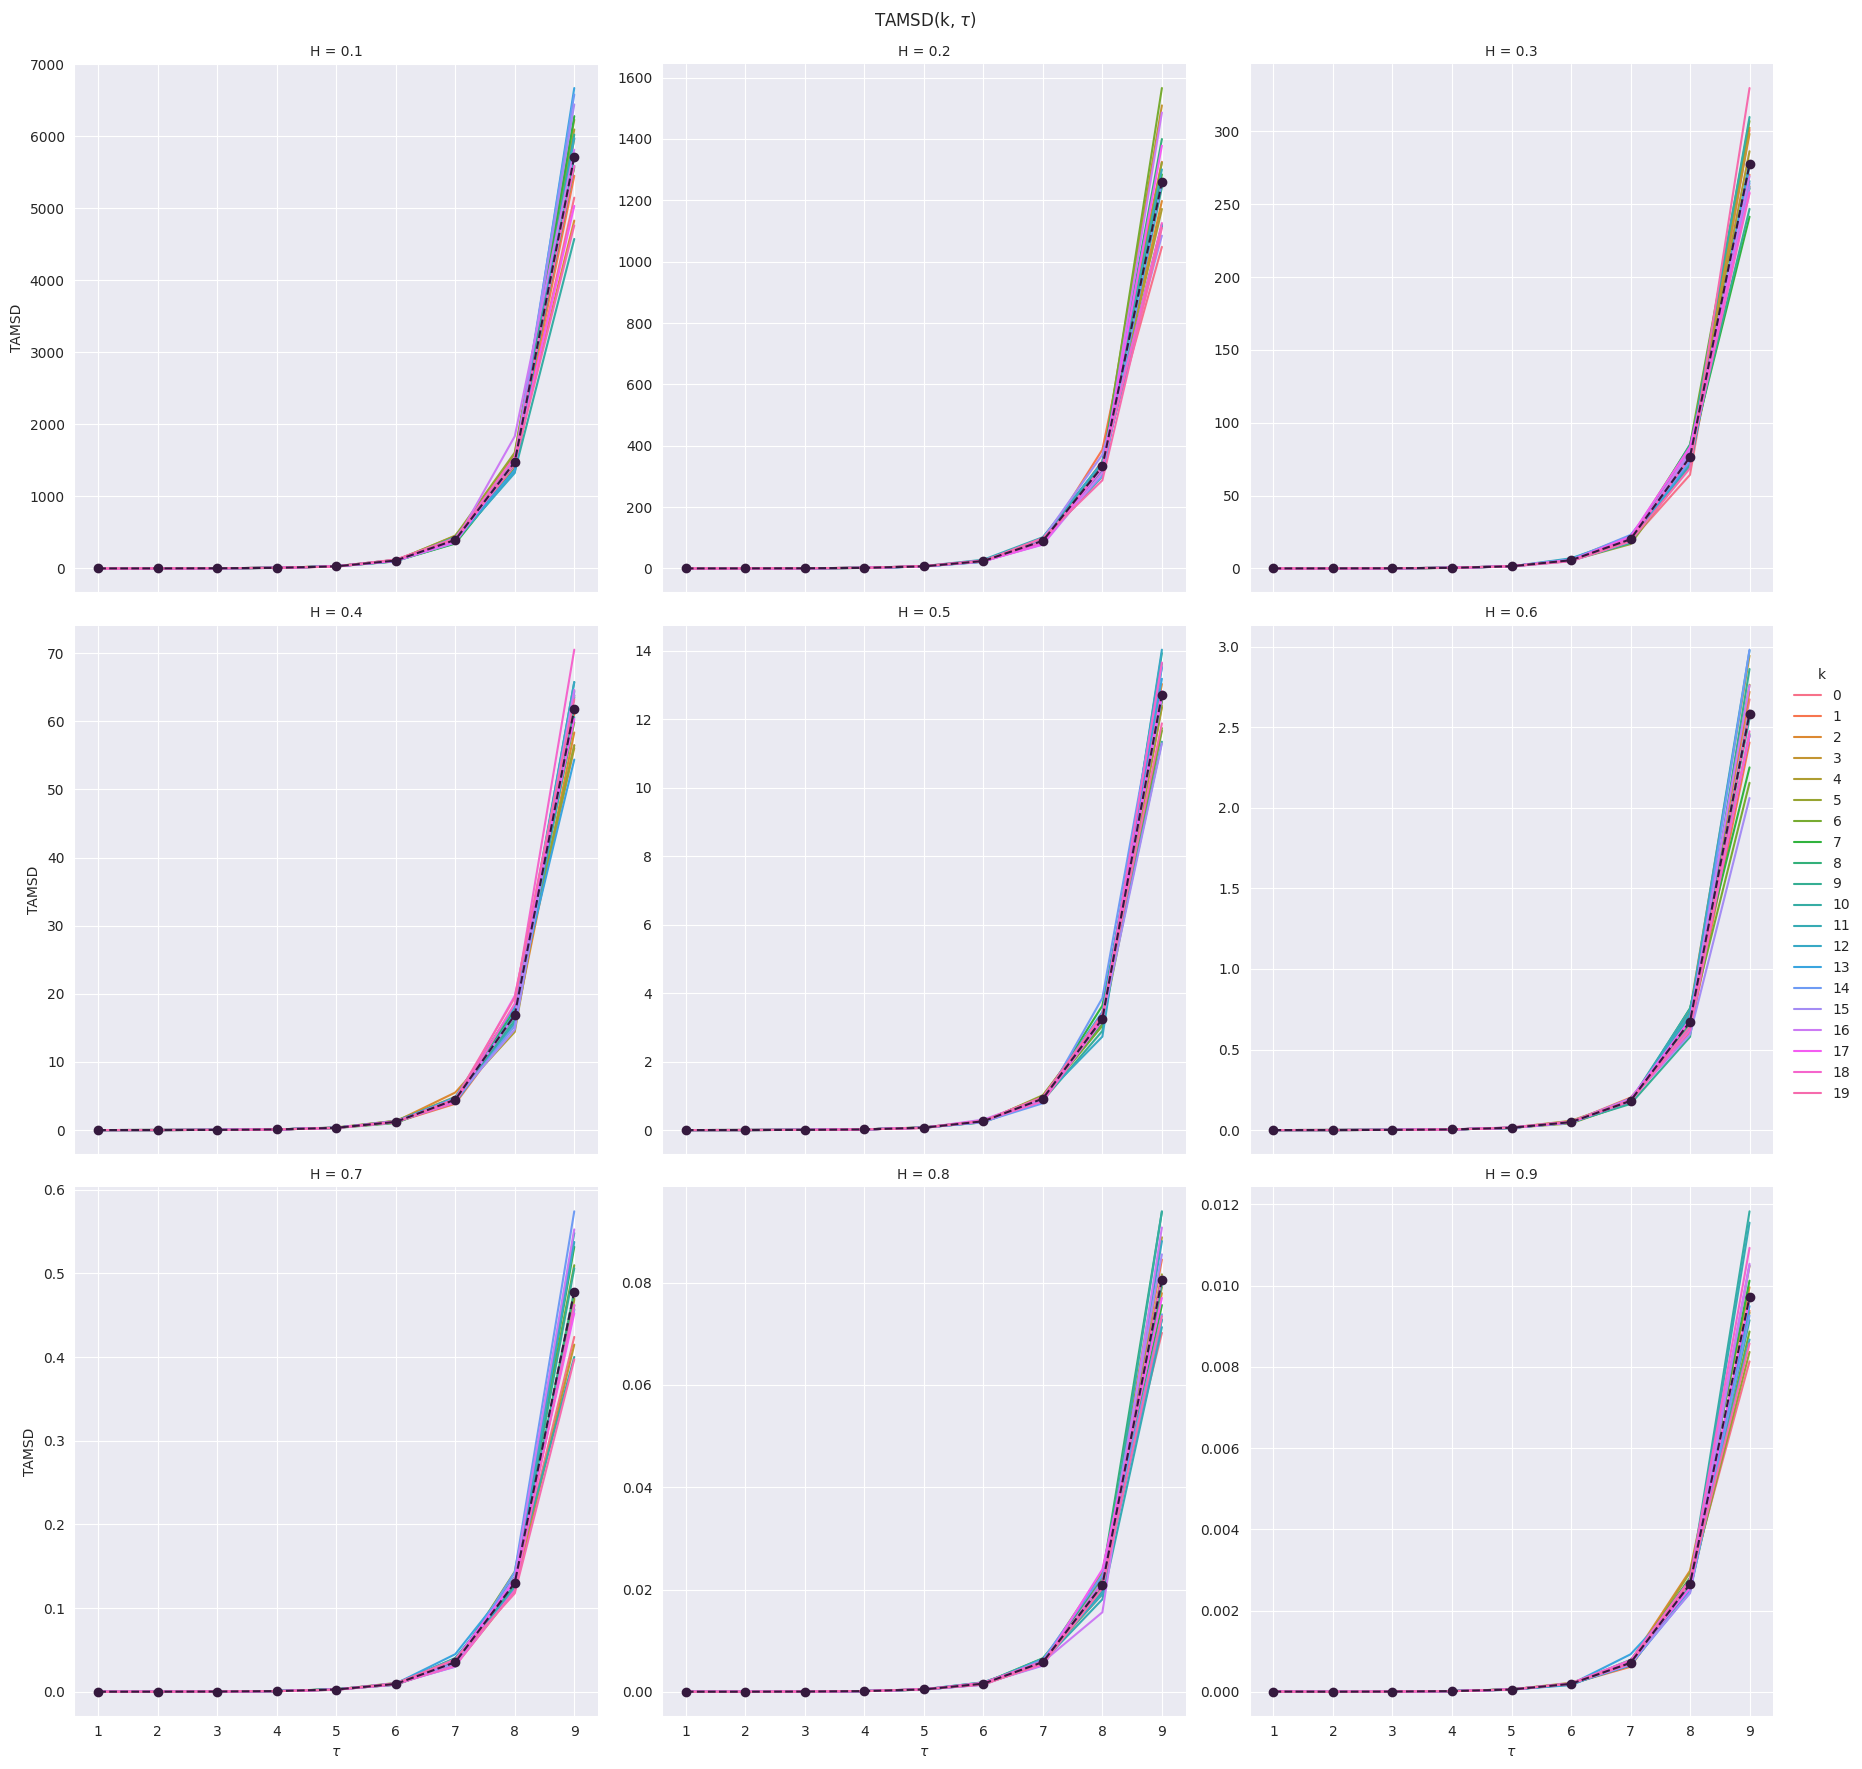

In [251]:
g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()

## questions

In [295]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1)


### stationary process

In [296]:
# Augmented Dickey-Fuller test
adfuller(fbm)[1] #pvalue> 0.05 so no stationary


0.26798740069464116

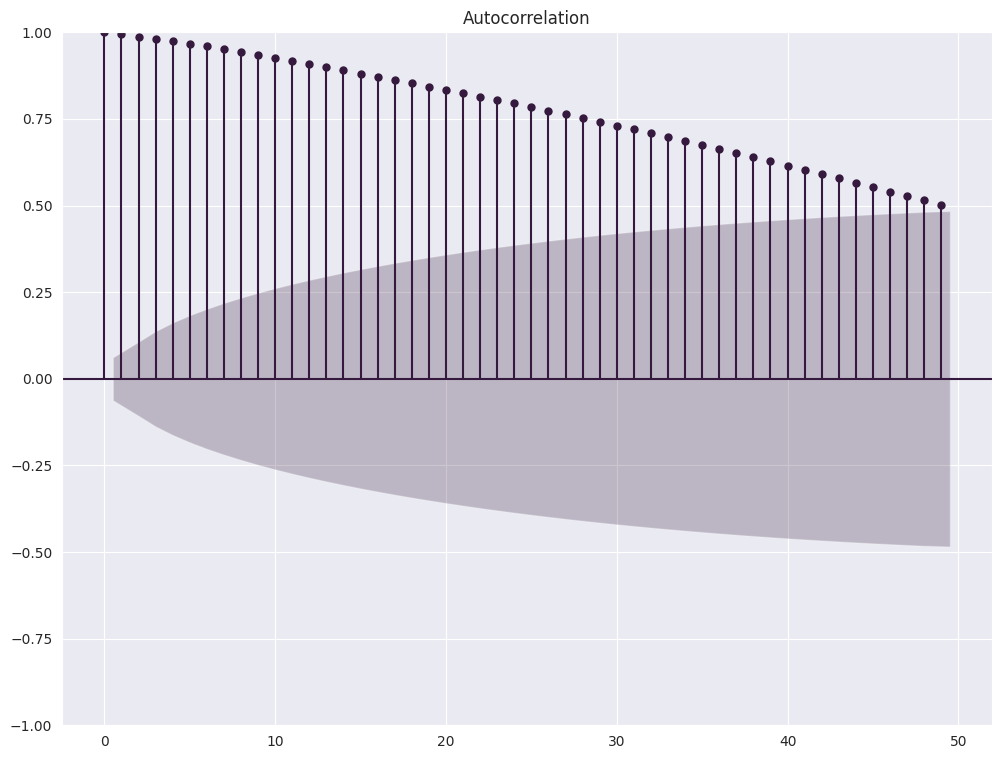

In [288]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(fbm, ax=ax, lags = range(0,50))
plt.show()

### are increments of the process stationary

In [48]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm = cholesky_fbm(T, n, H, trajectories= 1)
fbm_2 = cholesky_fbm(T/n, 2, H, trajectories= 2000)[-1]

In [49]:
adfuller(np.diff(fbm,1,0))[1] # pvalue < 0.05 nie odzucamy

0.0

### process distribution 

Process is gausain

In [387]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n), 
fix_fbm = cholesky_fbm(T, n, H, trajectories= 2000)[-1]

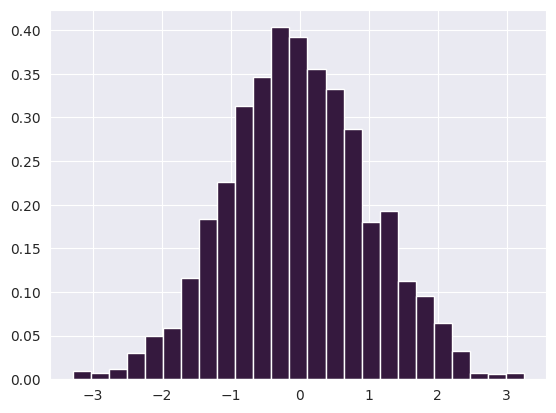

In [388]:
plt.hist(fix_fbm, bins = 25,density = True)
plt.show()

In [389]:
stats.shapiro(fix_fbm), stats.kstest(fix_fbm, 'norm'), stats.normaltest(fix_fbm), stats.jarque_bera(fix_fbm)

(ShapiroResult(statistic=0.9988774061203003, pvalue=0.23327530920505524),
 KstestResult(statistic=0.023171353713519194, pvalue=0.22958481566493494, statistic_location=-0.24990955661312358, statistic_sign=1),
 NormaltestResult(statistic=0.6340378628052985, pvalue=0.72831696693343),
 SignificanceResult(statistic=0.6496249959574791, pvalue=0.72266284168304))

### process increments distribution 

In [395]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm = cholesky_fbm(T, n, H, trajectories= 1)
diff_fix_fbm =  np.diff(np.squeeze(fbm))
teo_fbm = cholesky_fbm(T/n, n, H, trajectories= 2000)[-1]


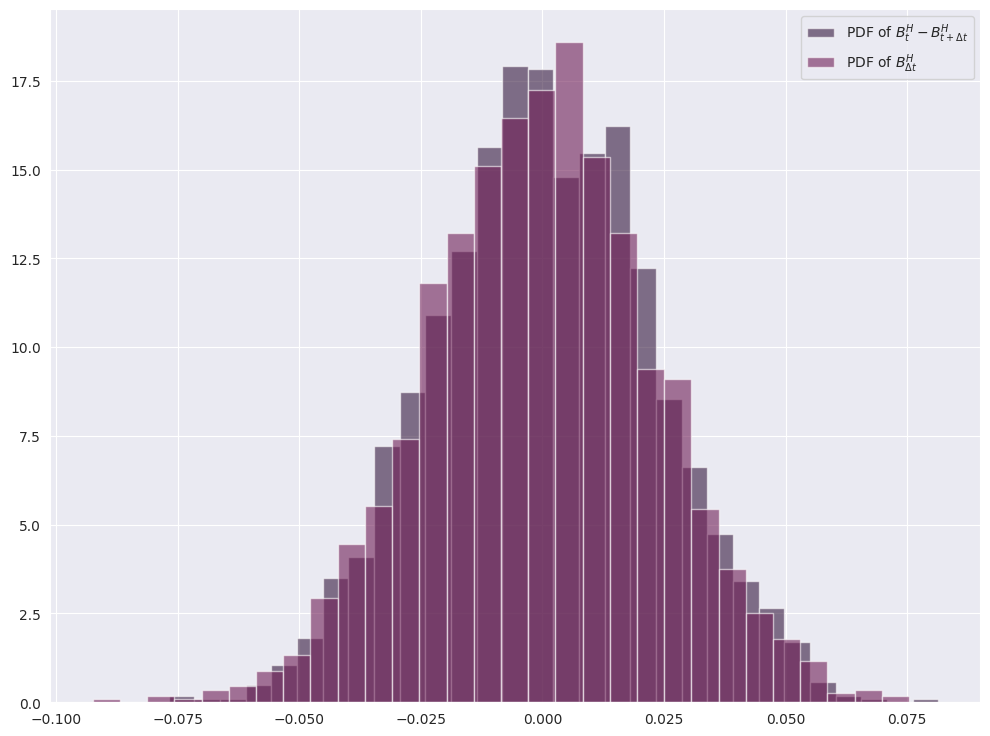

In [404]:
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_fbm, density=True, bins = 30, label = "PDF of $B^H_{t} - B^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_fbm, density=True, bins = 30, label = "PDF of $B^H_{\Delta t}$", alpha = 0.6)
plt.legend()
plt.show()

In [405]:
stats.kstest(diff_fix_fbm, teo_fbm) # duze p valiu nie odzucamy

KstestResult(statistic=0.025655077538769385, pvalue=0.5155017809109428, statistic_location=0.01230147568963988, statistic_sign=-1)

Quantile line fulfills power-low

### Self-similar

In [417]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm_1 = cholesky_fbm(T, n, H, trajectories=2000)
fbm_2 = cholesky_fbm(1, n, H, trajectories=2000)*T**H

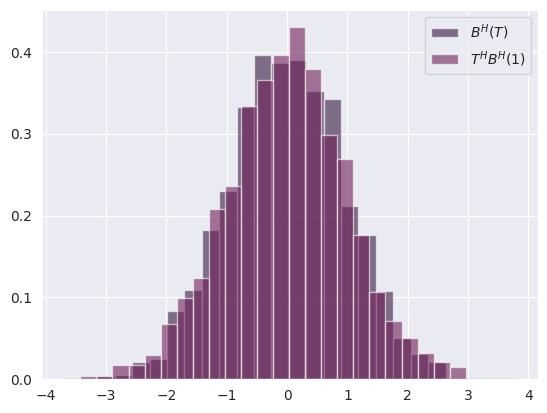

In [422]:
plt.hist(fbm_1[-1], label = "$B^H(T)$", alpha= 0.6, bins=25, density=True)
plt.hist(fbm_2[-1], label = "$T^HB^H(1)$", alpha= 0.6, bins=25, density  = True)
plt.legend()
plt.show()

In [423]:
stats.kstest(fbm_1[-1], fbm_2[-1]) # duze p valiu nie odzucamy

KstestResult(statistic=0.019, pvalue=0.8633028038475316, statistic_location=-0.9813838948014839, statistic_sign=-1)

# FOU

### FOU

\begin{gather}
    Y(t) = \sigma \int_{-\infty}^{t} e^{-\lambda(t-x)}dB^H_x\\
    dY_t = -\lambda Y_t dt + \sigma dB^H_t
\end{gather}

In [27]:
T = 1
n = 1000
H = 1/2
sigma = 1
lambd = 2
trajectories = 1000

ts = np.linspace(0, T, n) 

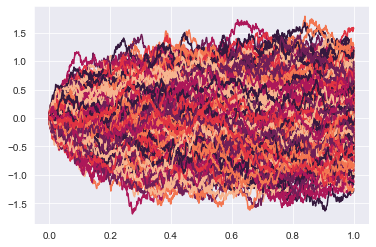

In [36]:
O_U = FOU(sigma, lambd, H, ts, trajectories = trajectories)
plt.plot(ts, O_U)
plt.show()

## Quantile line

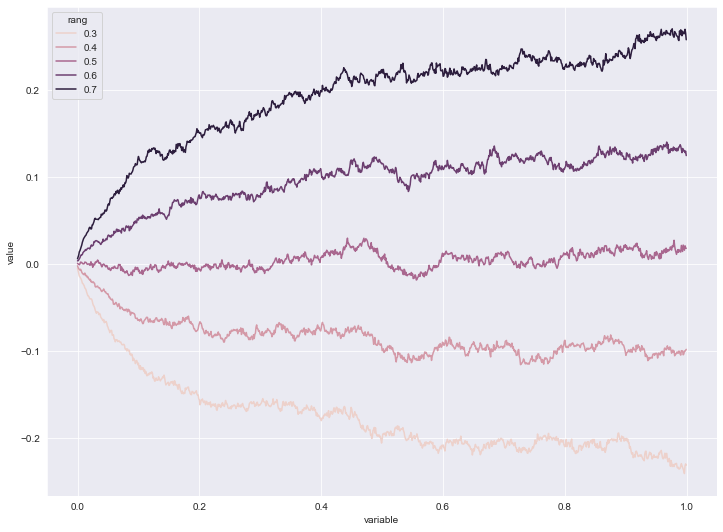

In [38]:
T = 1
n = 1000
H = 0.666
t_s = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)

fig, ax=plt.subplots(figsize=(12, 9))
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(O_U), quantiles, t_s)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(data=quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")
plt.savefig("latex/images/quantile_lines_OU_H_{H}.png")

## Variance in time

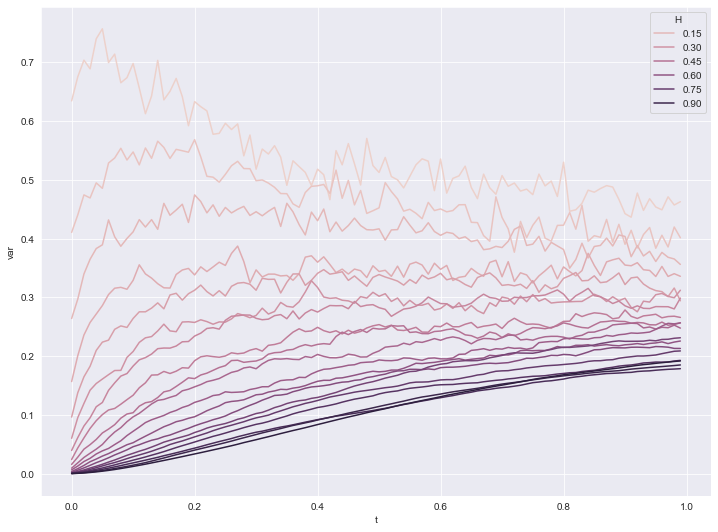

In [40]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
    _df = pd.DataFrame(np.var(O_U, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_O_U.png")
plt.show()

## MSD

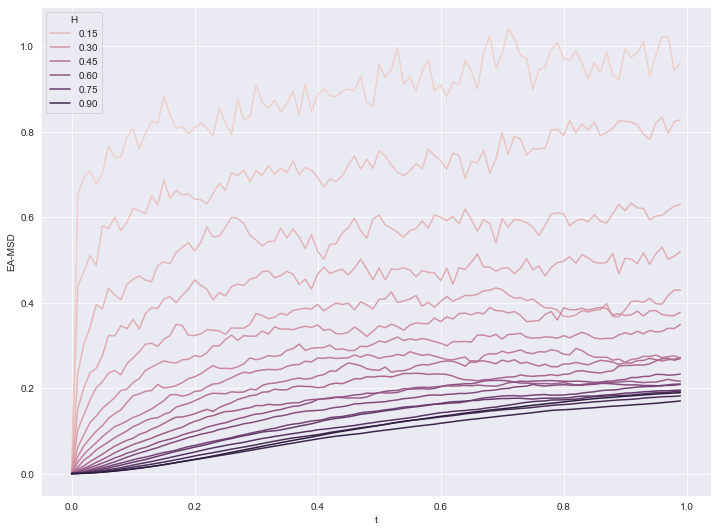

In [41]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
    _df = pd.DataFrame(EAMSD(O_U), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "EA-MSD", hue = "H")
plt.savefig("latex/images/EA-MSD_O_U.png")
plt.show()   

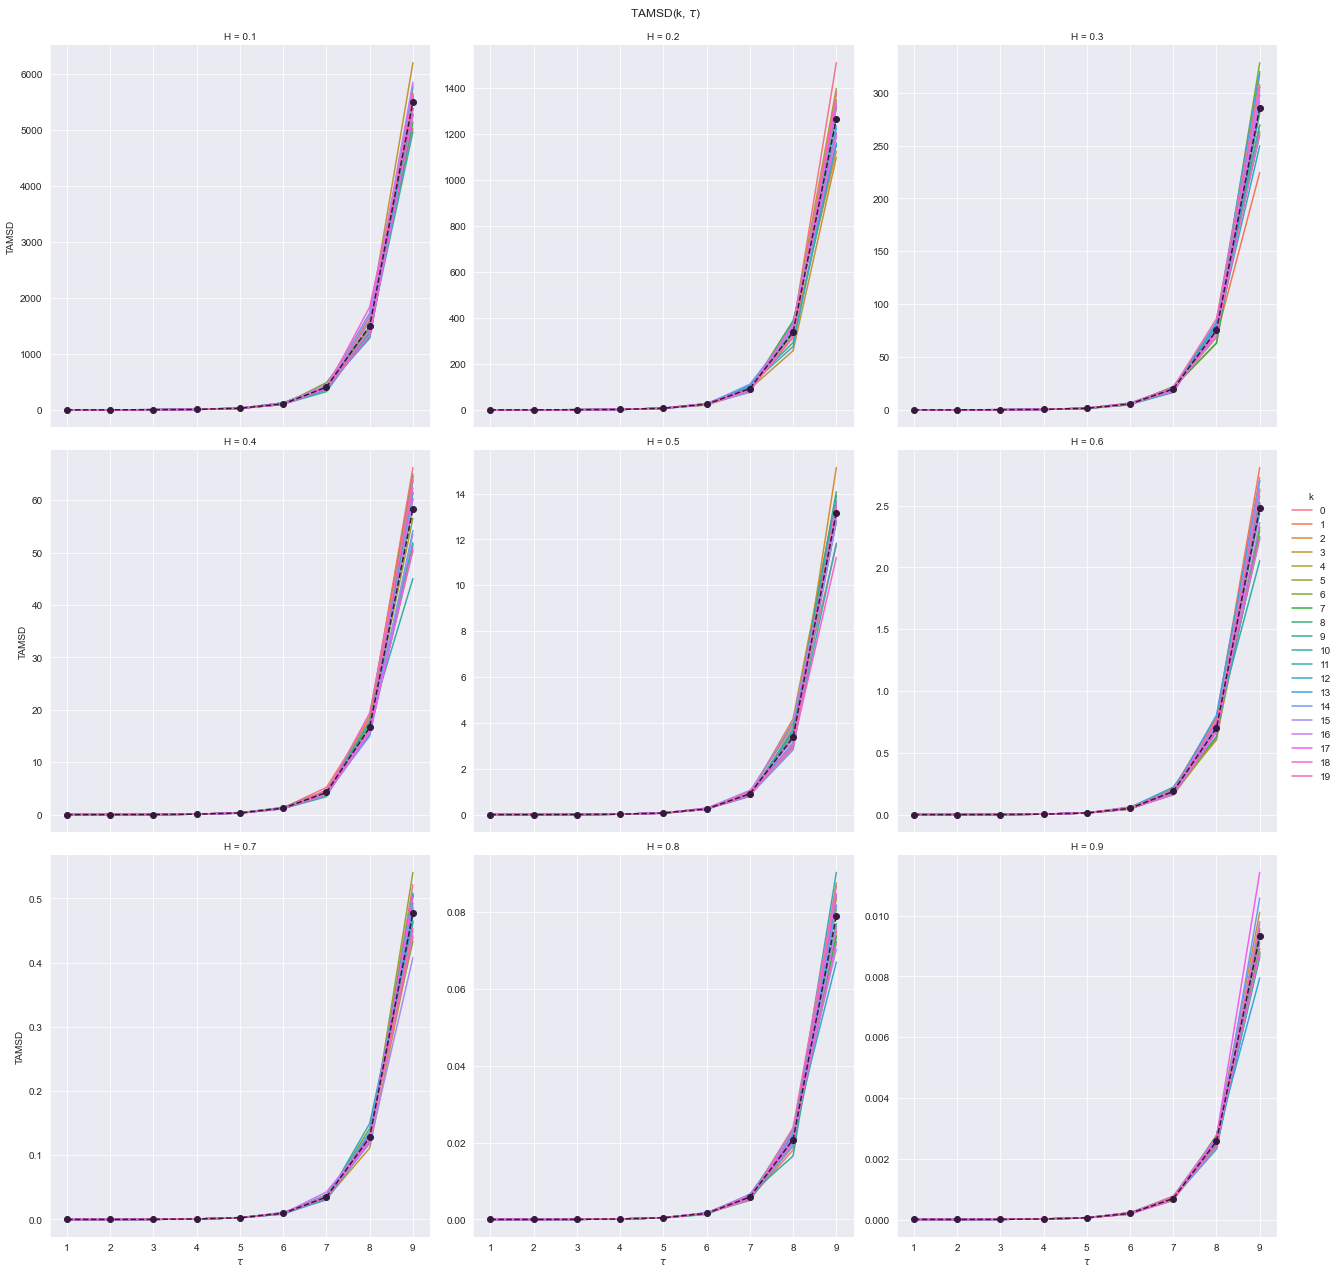

In [43]:
T = 1
n = 1000
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        O_U = FOU(sigma, lambd, H, ts, trajectories)
        _df = pd.DataFrame(TAMSD(O_U, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()

g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()

# Questions

## Stationary process

In [64]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories= 1)
# Augmented Dickey-Fuller test
adfuller(O_U)[1] #pvalue> 0.05 so no stationary

0.5419648260114387

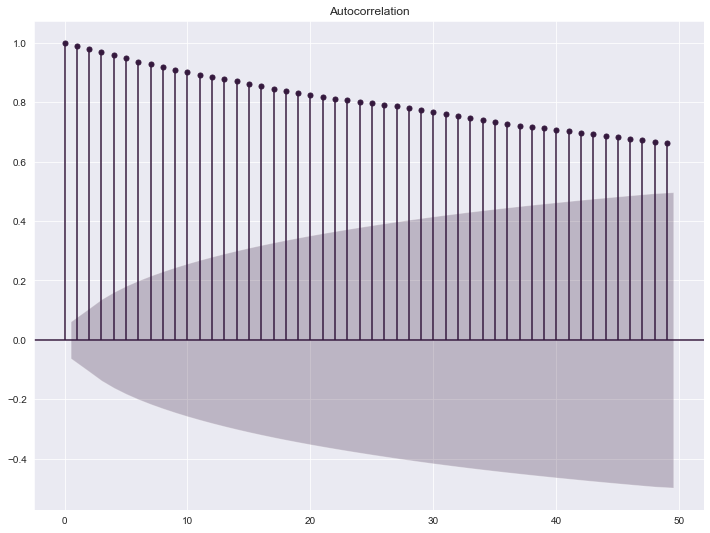

In [62]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories= 1)

# Augmented Dickey-Fuller test
adfuller(O_U)[1] #pvalue> 0.05 so no stationary
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(O_U, ax=ax, lags = range(0,50))
plt.show()

# Are increment

In [68]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts,  trajectories= 1)
O_U_2 = FOU(sigma, lambd, H, ts/2, trajectories= 2000)[-1]

adfuller(np.diff(O_U,1,0))[1] # pvalue < 0.05 nie odzucamy

0.0

## Process distribution
Proces is Gaussian

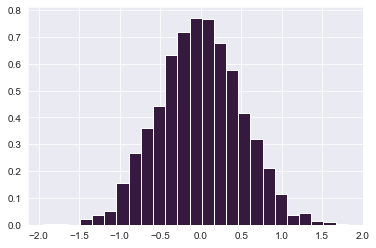

In [57]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
fix_O_U = FOU(sigma, lambd, H, ts, trajectories= 2000)[-1]
plt.hist(fix_O_U, bins = 25,density = True)
plt.show()

In [58]:
stats.shapiro(fix_O_U), stats.kstest(fix_O_U, 'norm'), stats.normaltest(fix_O_U), stats.jarque_bera(fix_O_U)

(ShapiroResult(statistic=0.9994549751281738, pvalue=0.8664813041687012),
 KstestResult(statistic=0.16488347542041504, pvalue=5.505271137765429e-48),
 NormaltestResult(statistic=0.4219450899786428, pvalue=0.8097962995421274),
 Jarque_beraResult(statistic=0.4460911518678659, pvalue=0.8000783841440169))

## Process increment distribution

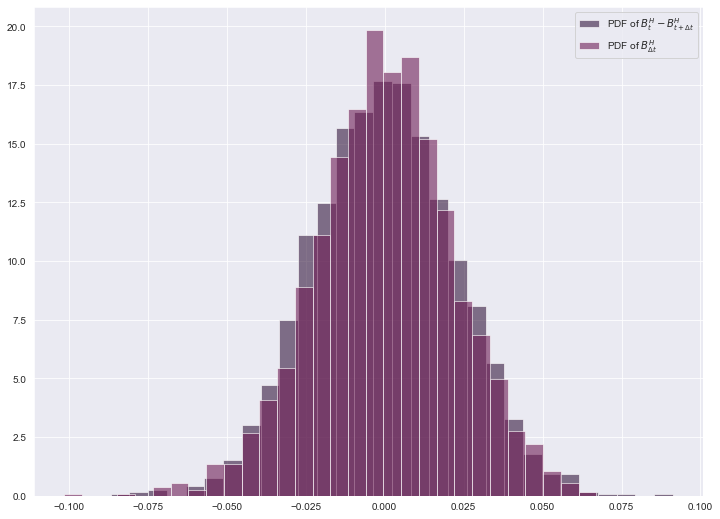

In [71]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1)
diff_fix_O_U =  np.diff(np.squeeze(O_U))
teo_O_U = FOU(sigma, lambd, H, ts/n, trajectories= 2000)[-1]
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_O_U, density=True, bins = 30, label = "PDF of $B^H_{t} - B^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_O_U, density=True, bins = 30, label = "PDF of $B^H_{\Delta t}$", alpha = 0.6)
plt.legend()
plt.show()

In [72]:
stats.kstest(diff_fix_O_U, teo_O_U) # duze p valiu nie odzucamy

KstestResult(statistic=0.034133066533266636, pvalue=0.18995116160081438)

### Self-similar

# NIE WIEM CZY TO DOBRZE

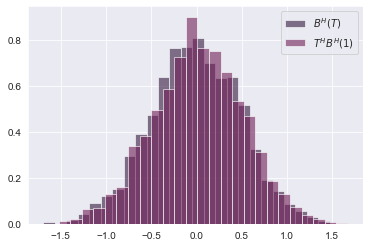

In [73]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n) 
O_U_1 = FOU(sigma, lambd, H, ts, trajectories=2000)
O_U_2 = FOU(sigma, lambd, H, ts/T, trajectories=2000)*T**H
plt.hist(O_U_1[-1], label = "$B^H(T)$", alpha= 0.6, bins=25, density=True)
plt.hist(O_U_2[-1], label = "$T^HB^H(1)$", alpha= 0.6, bins=25, density  = True)
plt.legend()
plt.show()



In [74]:

stats.kstest(O_U_1[-1], O_U_2[-1]) # duze p valiu nie odzucamy

KstestResult(statistic=0.0435, pvalue=0.04542866662680684)

# $\alpha-stable$

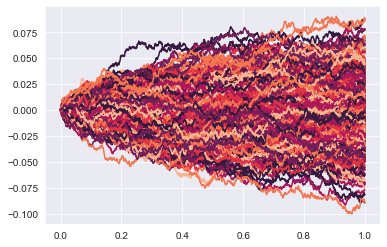

In [75]:
m =  100
M =  200
N = 1000
n =  500
H =1/2
alpha =  2
# gamma =  (T /N) ** H
ts = np.linspace(0, 1, N)

y = FAS(alpha, H, M, N, m, n)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
plt.plot(ts, FASM)
plt.show()

<AxesSubplot:xlabel='variable', ylabel='value'>

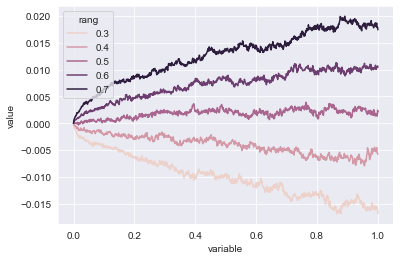

In [77]:
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(FASM), quantiles, ts)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(data=quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")

## Variancve in time

In [82]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 100)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T

In [83]:
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    y = FAS(alpha, H, M, N, m, 1000)*N**-H
    FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
    _df = pd.DataFrame(np.var(FASM, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

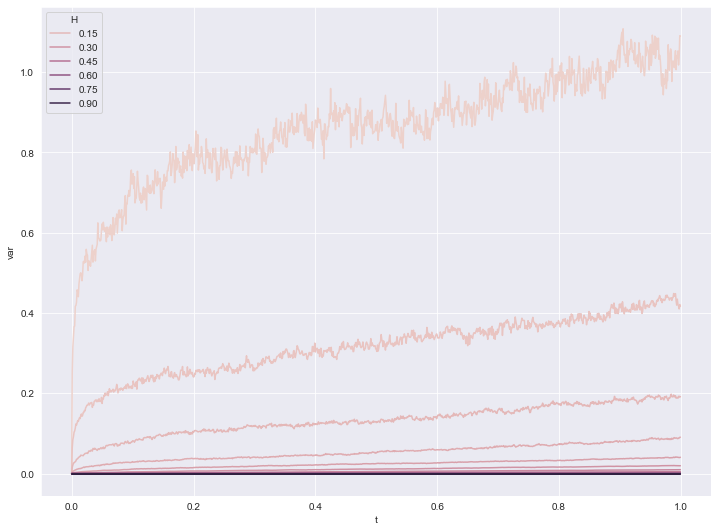

In [84]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_FASM.png")
plt.show()

## MSD

In [86]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1000)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    y = FAS(alpha, H, M, N, m, 1000)*N**-H
    FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
    _df = pd.DataFrame(EAMSD(FASM), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

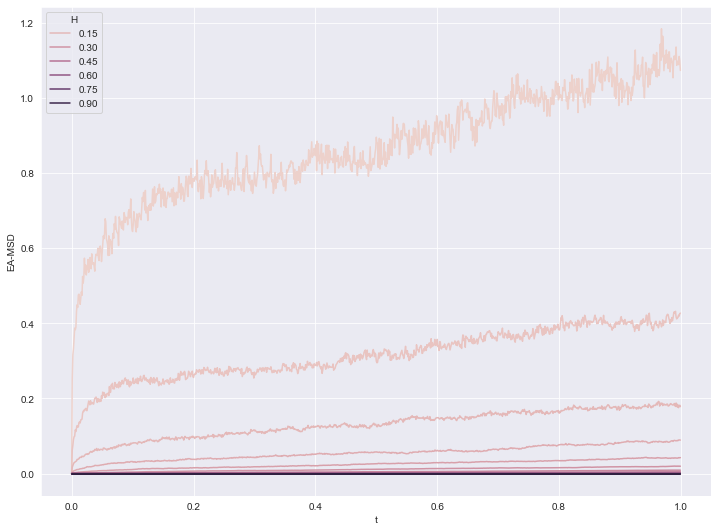

In [87]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "EA-MSD", hue = "H")
plt.show()


In [90]:
T = 1
n = 20
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        y = FAS(alpha, H, M, N, m, 20)*N**-H
        FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
        _df = pd.DataFrame(TAMSD(FASM, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()


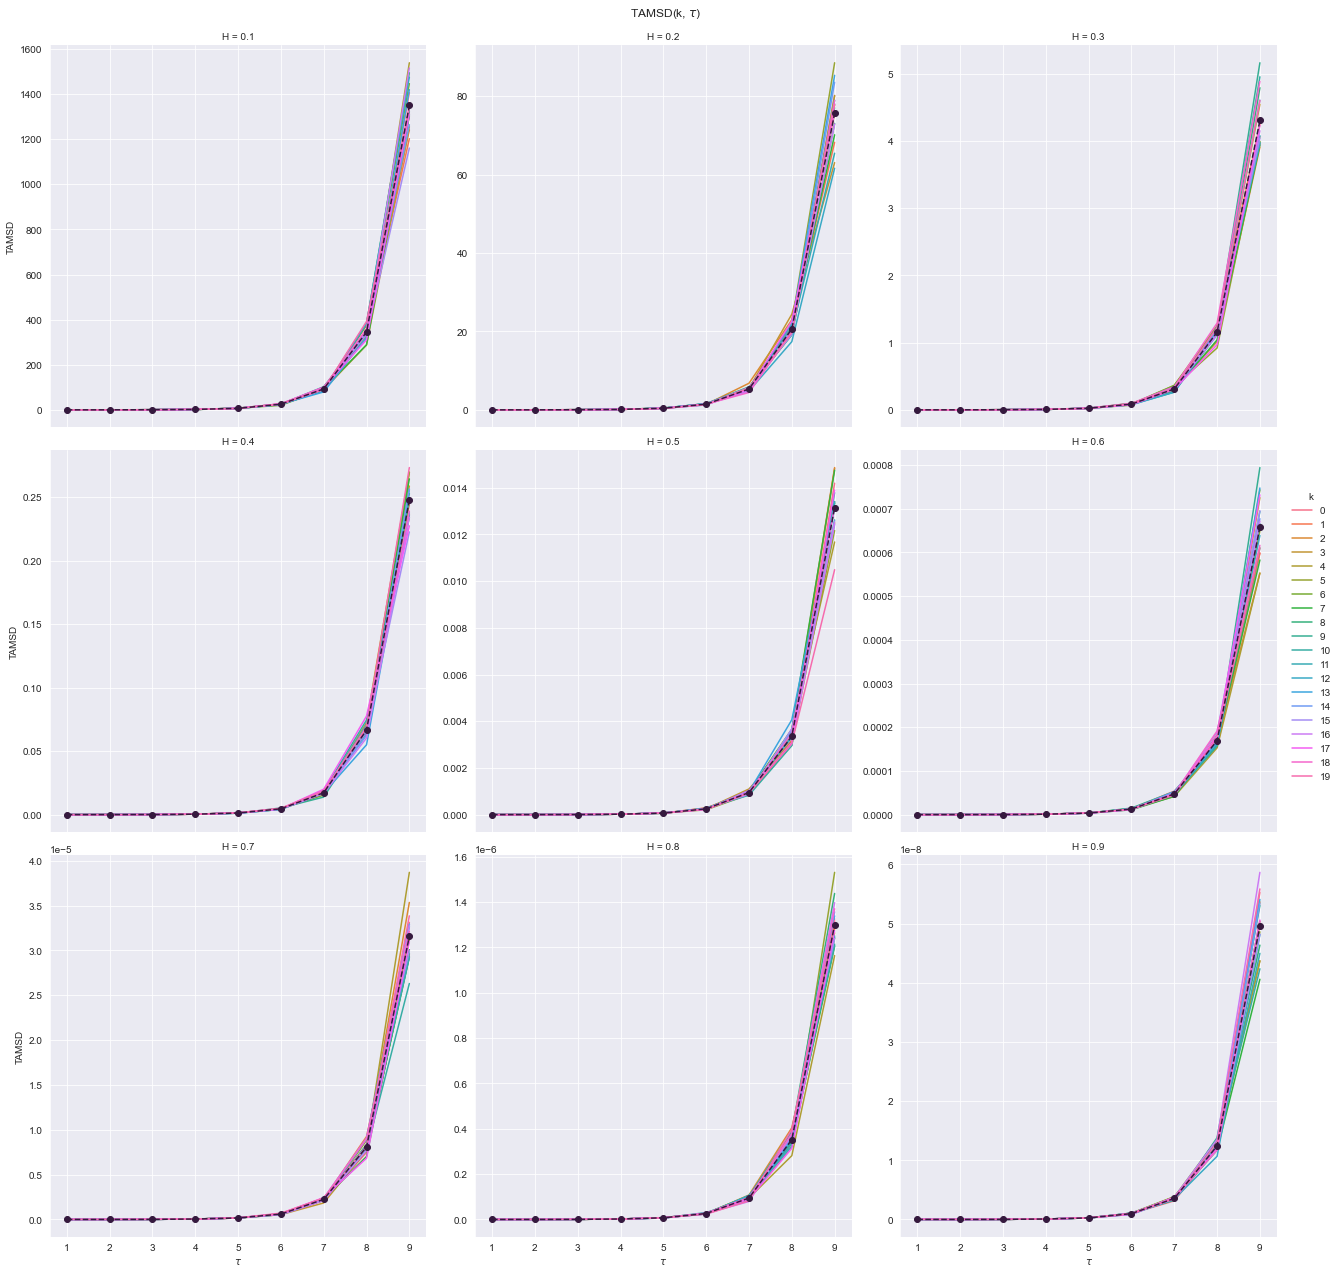

In [91]:
g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()


## questions

In [94]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T

### stationary process

In [95]:
### stationary process# Augmented Dickey-Fuller test
adfuller(FASM)[1] #pvalue> 0.05 so no stationary


0.5568022080999866

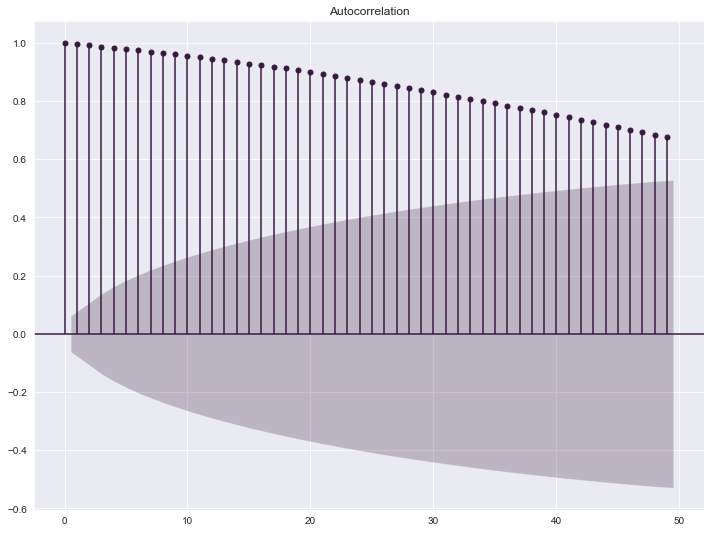

In [96]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(FASM, ax=ax, lags = range(0,50))
plt.show()

### are increments of the process stationary

In [98]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
y = FAS(alpha, H, M, N, m, 2000)*N**-H
FASM_2 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T[-1]

adfuller(np.diff(FASM,1,0))[1] # pvalue < 0.05 nie odzucamy

1.372374823792803e-24

### process distribution 

Process is gausain

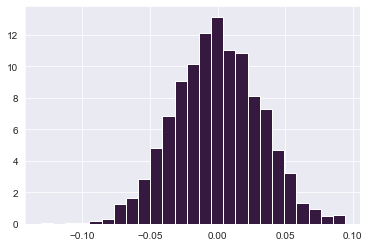

In [99]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 2000)*N**-H
fix_FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T[-1]

plt.hist(fix_FASM, bins = 25,density = True)
plt.show()### process increments distribution 

In [100]:
stats.shapiro(fix_FASM), stats.kstest(fix_FASM, 'norm'), stats.normaltest(fix_FASM), stats.jarque_bera(fix_FASM)

(ShapiroResult(statistic=0.9992609620094299, pvalue=0.6312829852104187),
 KstestResult(statistic=0.46424813749406163, pvalue=0.0),
 NormaltestResult(statistic=0.03725107353982514, pvalue=0.981546846636489),
 Jarque_beraResult(statistic=0.06760702189333413, pvalue=0.9667614440173248))

### process increments distribution 

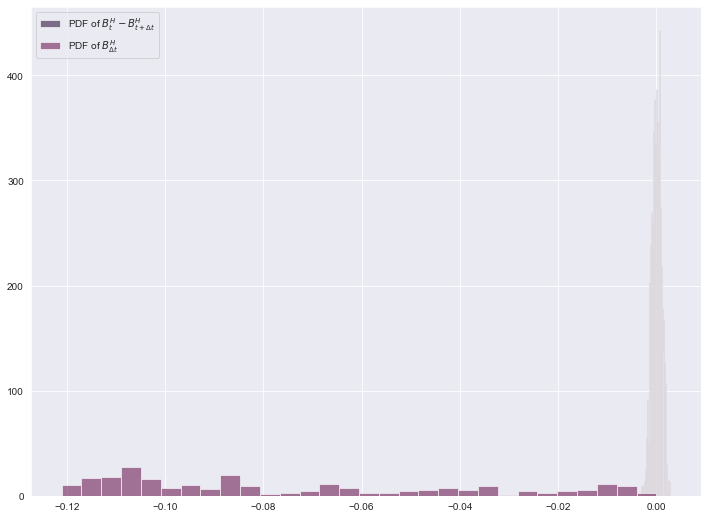

In [101]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n) 
y = FAS(alpha, H, M, N, m, 1)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)

diff_fix_FASM =  np.diff(np.squeeze(FASM))
y = FAS(alpha, H, M, N, m, 2000)*N**-H
teo_FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)[-1]

fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_FASM, density=True, bins = 30, label = "PDF of $B^H_{t} - B^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_FASM, density=True, bins = 30, label = "PDF of $B^H_{\Delta t}$", alpha = 0.6)
plt.legend()
plt.show()

In [ ]:
stats.kstest(diff_fix_FASM, teo_FASM) # duze p valiu nie odzucamy

### Self-similar

In [102]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n) 
y = FAS(alpha, H, M, N, m, 2000)*N**-H
FASM_1 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)

y = FAS(alpha, H, M, N, m, 2000)*N**-H
FASM_2 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)*T**H

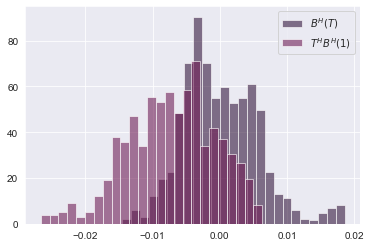

In [103]:
plt.hist(FASM_1[-1], label = "$B^H(T)$", alpha= 0.6, bins=25, density=True)
plt.hist(FASM_2[-1], label = "$T^HB^H(1)$", alpha= 0.6, bins=25, density  = True)
plt.legend()
plt.show()

In [104]:
stats.kstest(FASM_1[-1], FASM_2[-1]) # duze p valiu nie odzucamy

KstestResult(statistic=0.445, pvalue=1.8083688851037378e-89)

# ex 2

In [561]:
def check_time(a, b):
    if a==0:
        if b==0:
            return np.NAN
        else:
            return b
    elif b==0:
        if a==0 :
            return np.NAN
        else:
            return a
    else:
        return min(a, b)
    
def hit_time(X, a, b):
    return check_time(np.argmin(X<a),np.argmin(X>b))

In [508]:
alpha = 2
N = 1000
T = 1000
n = 1000
ts = np.linspace(0, T ,N)
# SaSL = alpha_stable_process(alpha, 0, N, T)
SaSLn = np.array([alpha_stable_process(alpha, 0, N, T) for _ in range(n)])

In [582]:
a_s = np.linspace(-40, 40, 100).round(4)
b_s = np.linspace(-40, 40, 100).round(4)
df = pd.DataFrame(columns=a_s, index=b_s)
df

,-40.0000,-39.1919,-38.3838,-37.5758,-36.7677,-35.9596,-35.1515,-34.3434,-33.5354,-32.7273,...,32.7273,33.5354,34.3434,35.1515,35.9596,36.7677,37.5758,38.3838,39.1919,40.0000
-40.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-39.1919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-38.3838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-37.5758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-36.7677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36.7677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37.5758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38.3838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39.1919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [583]:
for a in a_s:
    for b in b_s:
        if a>b:
            taus = np.apply_along_axis(hit_time, 0, SaSLn, a, b)
            df.loc[a, b] = np.nanmean(taus)


In [584]:
df

,-40.0000,-39.1919,-38.3838,-37.5758,-36.7677,-35.9596,-35.1515,-34.3434,-33.5354,-32.7273,...,32.7273,33.5354,34.3434,35.1515,35.9596,36.7677,37.5758,38.3838,39.1919,40.0000
-40.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-39.1919,40.654321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-38.3838,40.62963,40.190583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-37.5758,40.542088,40.103139,39.083799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-36.7677,40.387205,39.94843,38.929609,36.716518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36.7677,19.928495,19.884739,19.842049,19.647812,19.550694,20.293177,20.905218,21.36383,21.691083,21.656416,...,21.638207,21.638207,21.638207,21.638207,21.638207,NaN,NaN,NaN,NaN,NaN
37.5758,18.602358,18.558414,18.515541,18.320472,18.222937,18.959315,20.34188,23.51383,22.938429,22.743372,...,20.510182,20.510182,20.510182,20.510182,20.510182,20.510182,NaN,NaN,NaN,NaN
38.3838,18.806034,18.761853,18.71875,18.522629,18.424569,19.164693,20.358754,23.547594,24.681576,24.270701,...,21.082974,21.082974,21.082974,21.082974,21.082974,21.082974,21.082974,NaN,NaN,NaN
39.1919,19.714595,19.67027,19.242162,19.045405,18.766486,19.508639,20.695043,23.657725,24.654915,25.349628,...,22.134054,22.134054,22.134054,22.134054,22.134054,22.134054,22.134054,22.134054,NaN,NaN


In [599]:
a_s = np.linspace(-2, 2, 4).round(4)
b_s = np.linspace(-2, 2, 4).round(4)
df_2 = pd.DataFrame(columns=a_s, index=b_s)
for a in a_s:
    for b in b_s:
        if a>b:
            taus = np.apply_along_axis(hit_time, 0, SaSLn, a, b)
            df_2.loc[a, b] = np.nanmean(taus)
df_2

,-2.0000,-0.6667,0.6667,2.0000
-2.0000,NaN,NaN,NaN,NaN
-0.6667,2.530531,NaN,NaN,NaN
0.6667,2.342342,2.252252,NaN,NaN
2.0000,2.128128,2.057057,1.980981,NaN


In [552]:
np.apply_along_axis(sum, 0, np.array([[0,0,0],[1,1,1],[2,2,2]]))

array([3, 3, 3])

In [603]:
df.index = df.index.map(str)

TypeError: Image data of dtype object cannot be converted to float

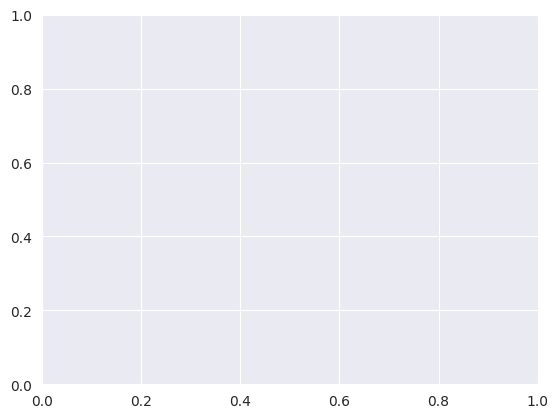

In [602]:
sns.heatmap(df, mask=df.isnull())  